In [1]:
import torch
import random
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

import json
import os
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt

from torch import nn
from torch.nn import functional as F

import numpy as np
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter
import shutil

In [2]:
import os
import shutil
from google.colab import drive

drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/COCO_Filtered'
annotations_path = os.path.join(DATA_PATH, 'annotations')

os.makedirs(annotations_path, exist_ok=True)

annotations_file = os.path.join(annotations_path, 'instances_train2017.json')

Mounted at /content/drive


Download the annotation file

In [ ]:
if not os.path.exists(annotations_file):
    print("The annotation file is not present, I will download it now...")
    !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O /content/annotations_trainval2017.zip

    # Decomprimiamo il file zip
    print("Decompressing annotations...")
    !unzip /content/annotations_trainval2017.zip -d /content/

    # Sposta il file delle annotazioni
    shutil.move('/content/annotations/instances_train2017.json', annotations_file)
    print("Annotation file moved correctly.")
else:
    print(f"The annotations are already present in: {annotations_file}")

The annotations are already present in: /content/drive/MyDrive/COCO_Filtered/annotations/instances_train2017.json


#HYPERPARAMETERS

In [3]:

DATA_PATH = '/content/drive/MyDrive/COCO_Filtered'
CLASSES_PATH = os.path.join(DATA_PATH, 'annotations/filtered_instances_train2017.json')


BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 1E-4

EPSILON = 1E-6
IMAGE_SIZE = (416, 416)

S = 7
B = 2
C = 4

NUM_WORKERS = os.cpu_count()

AUSILIAR FUNCTION

In [4]:
def get_iou(p, a):
    """Intersection-over-Union between two boxes"""
    p_tl, p_br = bbox_to_coords(p)  # (batch, S, S, B, 2)
    a_tl, a_br = bbox_to_coords(a)

    coords_join_size = (-1, -1, -1, B, B, 2)
    tl = torch.max(
        p_tl.unsqueeze(4).expand(coords_join_size),
        a_tl.unsqueeze(3).expand(coords_join_size)
    )
    br = torch.min(
        p_br.unsqueeze(4).expand(coords_join_size),
        a_br.unsqueeze(3).expand(coords_join_size)
    )

    intersection_sides = torch.clamp(br - tl, min=0.0)
    intersection = intersection_sides[..., 0] * intersection_sides[..., 1]  # (batch, S, S, B, B)

    p_area = bbox_attr(p, 2) * bbox_attr(p, 3)
    p_area = p_area.unsqueeze(4).expand_as(intersection)

    a_area = bbox_attr(a, 2) * bbox_attr(a, 3)
    a_area = a_area.unsqueeze(3).expand_as(intersection)

    union = p_area + a_area - intersection

    zero_unions = (union == 0.0)
    union[zero_unions] = EPSILON
    intersection[zero_unions] = 0.0

    return intersection / union

def bbox_to_coords(t):
    """Change bounding box format from [x, y, width, height] to ([x1, y1], [x2, y2])"""
    width = bbox_attr(t, 2)
    x = bbox_attr(t, 0)
    x1 = x - width / 2.0
    x2 = x + width / 2.0

    height = bbox_attr(t, 3)
    y = bbox_attr(t, 1)
    y1 = y - height / 2.0
    y2 = y + height / 2.0

    return torch.stack((x1, y1), dim=4), torch.stack((x2, y2), dim=4)

def scheduler_lambda(epoch):
    """Function for scheduling the learning rate according to epoch."""
    if epoch < WARMUP_EPOCHS + 75:
        return 1
    elif epoch < WARMUP_EPOCHS + 105:
        return 0.1
    else:
        return 0.01

def bbox_attr(data, i):
    """Returns the i-th property of each bounding box in date."""
    attr_start = C + i
    return data[..., attr_start::5]

def get_overlap(a, b):
    """Returns the overlap proportion between two boxes (format [top-left, width, height, confidence, class])."""
    a_tl, a_width, a_height, _, _ = a
    b_tl, b_width, b_height, _, _ = b

    i_tl = (max(a_tl[0], b_tl[0]), max(a_tl[1], b_tl[1]))
    i_br = (min(a_tl[0] + a_width, b_tl[0] + b_width), min(a_tl[1] + a_height, b_tl[1] + b_height))

    intersection = max(0, i_br[0] - i_tl[0]) * max(0, i_br[1] - i_tl[1])

    a_area = a_width * a_height
    b_area = b_width * b_height

    a_intersection = b_intersection = intersection
    if a_area == 0:
        a_intersection = 0
        a_area = EPSILON
    if b_area == 0:
        b_intersection = 0
        b_area = EPSILON

    return torch.max(a_intersection / a_area, b_intersection / b_area).item()

def plot_boxes(data, labels, classes, color='orange', min_confidence=0.3, max_overlap=0.5, file=None):
    """Draws bounding boxes on the image (data) according to the labels.
    If ‘file’ is specified, saves the image, otherwise shows it."""
    grid_size_x = data.size(dim=2) / S
    grid_size_y = data.size(dim=1) / S
    m = labels.size(dim=0)
    n = labels.size(dim=1)

    bboxes = []
    for i in range(m):
        for j in range(n):
            for k in range((labels.size(dim=2) - C) // 5):
                bbox_start = 5 * k + C
                bbox_end = 5 * (k + 1) + C
                bbox = labels[i, j, bbox_start:bbox_end]
                class_index = torch.argmax(labels[i, j, :C]).item()
                confidence = labels[i, j, class_index].item() * bbox[4].item()  # pr(c) * IoU
                if confidence > min_confidence:
                    width = bbox[2] * IMAGE_SIZE[0]
                    height = bbox[3] * IMAGE_SIZE[1]
                    tl = (bbox[0] * IMAGE_SIZE[0] + j * grid_size_x - width / 2,
                          bbox[1] * IMAGE_SIZE[1] + i * grid_size_y - height / 2)
                    bboxes.append([tl, width, height, confidence, class_index])

    bboxes = sorted(bboxes, key=lambda x: x[3], reverse=True)

    num_boxes = len(bboxes)
    iou = [[0 for _ in range(num_boxes)] for _ in range(num_boxes)]
    for i in range(num_boxes):
        for j in range(num_boxes):
            iou[i][j] = get_overlap(bboxes[i], bboxes[j])

    image = T.ToPILImage()(data)
    draw = ImageDraw.Draw(image)
    discarded = set()
    for i in range(num_boxes):
        if i not in discarded:
            tl, width, height, confidence, class_index = bboxes[i]
            for j in range(num_boxes):
                other_class = bboxes[j][4]
                if j != i and other_class == class_index and iou[i][j] > max_overlap:
                    discarded.add(j)
            draw.rectangle((tl, (tl[0] + width, tl[1] + height)), outline=color)
            text_pos = (max(0, tl[0]), max(0, tl[1] - 11))
            text = f'{classes[class_index]} {round(confidence * 100, 1)}%'
            text_bbox = draw.textbbox(text_pos, text)
            draw.rectangle(text_bbox, fill=color)
            draw.text(text_pos, text)
    if file is None:
        display(image)
    else:
        output_dir = os.path.dirname(file)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        if not file.endswith('.png'):
            file += '.png'
        image.save(file)

In [ ]:
original_annotations_path = '/content/drive/MyDrive/COCO_Filtered/annotations/instances_train2017.json'
filtered_annotations_path = '/content/drive/MyDrive/COCO_Filtered/annotations/filtered_instances_train2017.json'

desired_classes = ['truck', 'car', 'motorcycle', 'bus']

# Load original annotations
with open(original_annotations_path, 'r') as f:
    coco_data = json.load(f)

# Mapp from category_id to name (for filtering the annotations)
categories = coco_data['categories']
cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
class_ids = [cat['id'] for cat in categories if cat['name'] in desired_classes]

# Filter annotations for the desired classes
filtered_annotations = {
    'images': coco_data['images'],
    'annotations': [],
    'categories': [cat for cat in categories if cat['name'] in desired_classes]
}

for ann in coco_data['annotations']:
    if ann['category_id'] in class_ids:
        filtered_annotations['annotations'].append(ann)

# Save filtered annotations
with open(filtered_annotations_path, 'w') as f:
    json.dump(filtered_annotations, f)

print(f"Filtered annotation file saved in: {filtered_annotations_path}")

Filtered annotation file saved in: /content/drive/MyDrive/COCO_Filtered/annotations/filtered_instances_train2017.json


#Definition of the COCODataset class

In [5]:
class COCODataset(Dataset):
    def __init__(self, set_type, normalize=False, augment=False):

        assert set_type in {'train', 'test', 'valid'}
        self.set_type = set_type
        self.normalize = normalize
        self.augment = augment

        # Directory of the images for the selcected one set
        self.images_dir = os.path.join(DATA_PATH, "images")

        # Load annotations coco
        ann_file = os.path.join(DATA_PATH, 'annotations', 'filtered_instances_train2017.json')
        with open(ann_file, 'r') as f:
            coco_data = json.load(f)
        self.images_info = coco_data['images']
        self.annotations = coco_data['annotations']
        self.categories = coco_data['categories']

        # map
        self.img_id_to_anns = {}
        for ann in self.annotations:
            image_id = ann['image_id']
            if image_id not in self.img_id_to_anns:
                self.img_id_to_anns[image_id] = []
            self.img_id_to_anns[image_id].append(ann)

        self.cat_id_to_name = {cat['id']: cat['name'] for cat in self.categories}

        self.vehicle_classes = ['truck', 'car', 'motorcycle', 'bus']
        self.class_to_idx = {cls: i for i, cls in enumerate(self.vehicle_classes)}

        # Filter images, keeping only those in the specific folder
        filtered_images = []
        for img in self.images_info:
            img_path = os.path.join(self.images_dir, img['file_name'])
            if os.path.exists(img_path):
                filtered_images.append(img)
        self.images_info = filtered_images

        # Define basic transformation for images (scaling and tensor conversion)
        self.transform = T.Compose([
            T.Resize(IMAGE_SIZE),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.images_info)

    def __getitem__(self, idx):
        img_info = self.images_info[idx]
        img_path = os.path.join(self.images_dir, img_info['file_name'])
        image = Image.open(img_path).convert('RGB')
        original_image = image.copy()

        # Original dimensions before risizing
        orig_width = img_info['width']
        orig_height = img_info['height']

        # Risize
        image = image.resize(IMAGE_SIZE)
        data = self.transform(image)  # Tensor (3, H, W)

        # augmentation (traslation and scaling)
        x_shift = int((0.2 * random.random() - 0.1) * IMAGE_SIZE[0])
        y_shift = int((0.2 * random.random() - 0.1) * IMAGE_SIZE[1])
        scale_factor = 1 + 0.2 * random.random()

        if self.augment:
            data = TF.affine(data, angle=0.0, translate=(x_shift, y_shift), scale=scale_factor, shear=0.0)
            data = TF.adjust_hue(data, 0.2 * random.random() - 0.1)
            data = TF.adjust_saturation(data, 0.2 * random.random() + 0.9)
        if self.normalize:
            data = TF.normalize(data, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        # Calculate grid cell size
        grid_size_x = IMAGE_SIZE[0] / S  # width of cell
        grid_size_y = IMAGE_SIZE[1] / S  # high of cell

        # Initialization of the tensor ground truth: dimension (S, S, 5*B + C)
        depth = 5 * B + C
        ground_truth = torch.zeros((S, S, depth))
        boxes = {}
        class_names = {}

        # Retrieve annotations for this image
        anns = self.img_id_to_anns.get(img_info['id'], [])
        for ann in anns:
            # Convert category name to lower case for comparison
            cat_name = self.cat_id_to_name[ann['category_id']].lower()
            if cat_name not in self.vehicle_classes:
                continue
            class_index = self.class_to_idx[cat_name]
            # COCO: bb in the form [x, y, width, height]
            bbox = ann['bbox']
            x_min = bbox[0]
            y_min = bbox[1]
            x_max = x_min + bbox[2]
            y_max = y_min + bbox[3]

            # Scale co-ordinates from original image to IMAGE_SIZE
            scale_x = IMAGE_SIZE[0] / orig_width
            scale_y = IMAGE_SIZE[1] / orig_height
            x_min *= scale_x
            x_max *= scale_x
            y_min *= scale_y
            y_max *= scale_y

            # Applies augmentation to labels if required
            if self.augment:
                half_width = IMAGE_SIZE[0] / 2
                half_height = IMAGE_SIZE[1] / 2
                x_min = scale_bbox_coord(x_min, half_width, scale_factor) + x_shift
                x_max = scale_bbox_coord(x_max, half_width, scale_factor) + x_shift
                y_min = scale_bbox_coord(y_min, half_height, scale_factor) + y_shift
                y_max = scale_bbox_coord(y_max, half_height, scale_factor) + y_shift

            # center of bb
            mid_x = (x_min + x_max) / 2
            mid_y = (y_min + y_max) / 2
            col = int(mid_x // grid_size_x)
            row = int(mid_y // grid_size_y)

            if 0 <= col < S and 0 <= row < S:
                cell = (row, col)
                if cell not in class_names or cat_name == class_names[cell]:
                    one_hot = torch.zeros(C)
                    one_hot[class_index] = 1.0
                    ground_truth[row, col, :C] = one_hot
                    class_names[cell] = cat_name

                    # Insert bounding box in ground truth
                    bbox_index = boxes.get(cell, 0)
                    if bbox_index < B:
                        bbox_truth = (
                            (mid_x - col * grid_size_x) / IMAGE_SIZE[0],
                            (mid_y - row * grid_size_y) / IMAGE_SIZE[1],
                            (x_max - x_min) / IMAGE_SIZE[0],
                            (y_max - y_min) / IMAGE_SIZE[1],
                            1.0
                        )
                        bbox_start = 5 * bbox_index + C
                        ground_truth[row, col, bbox_start:] = torch.tensor(bbox_truth).repeat(B - bbox_index)
                        boxes[cell] = bbox_index + 1

        original_data = T.ToTensor()(original_image.resize(IMAGE_SIZE))
        return data, ground_truth, original_data

def scale_bbox_coord(coord, center, scale):
    return ((coord - center) * scale) + center

Creation of dataset, dataloader and extraction of a batch

In [ ]:
from torch.utils.data import DataLoader

dataset = COCODataset(set_type='train', normalize=True, augment=True)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for batch in dataloader:
    images, ground_truth, original_images = batch
    print(f"Images shape: {images.shape}")
    print(f"Ground truth shape: {ground_truth.shape}")
    break

Images shape: torch.Size([4, 3, 416, 416])
Ground truth shape: torch.Size([4, 7, 7, 14])


Load the adapted COCO dataset for the set ‘train’

Number of images in the set: 1000
Example nr. 1:


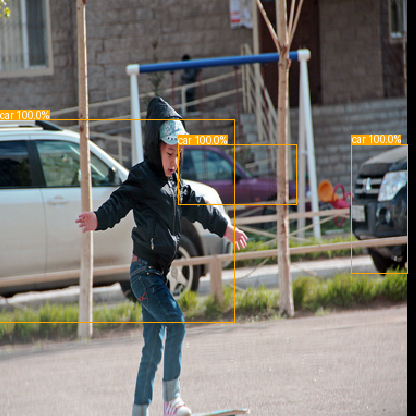

Example's shape: torch.Size([3, 416, 416])
Label's shape: torch.Size([7, 7, 14])
Original example's shape: torch.Size([3, 416, 416])
Label's support (positions of nonzeros): tensor([[ 2,  3,  1],
        [ 2,  3,  4],
        [ 2,  3,  5],
        [ 2,  3,  6],
        [ 2,  3,  7],
        [ 2,  3,  8],
        [ 2,  3,  9],
        [ 2,  3, 10],
        [ 2,  3, 11],
        [ 2,  3, 12],
        [ 2,  3, 13],
        [ 3,  1,  1],
        [ 3,  1,  4],
        [ 3,  1,  5],
        [ 3,  1,  6],
        [ 3,  1,  7],
        [ 3,  1,  8],
        [ 3,  1,  9],
        [ 3,  1, 10],
        [ 3,  1, 11],
        [ 3,  1, 12],
        [ 3,  1, 13],
        [ 3,  6,  1],
        [ 3,  6,  4],
        [ 3,  6,  5],
        [ 3,  6,  6],
        [ 3,  6,  7],
        [ 3,  6,  8],
        [ 3,  6,  9],
        [ 3,  6, 10],
        [ 3,  6, 11],
        [ 3,  6, 12],
        [ 3,  6, 13]])
Example nr. 2:


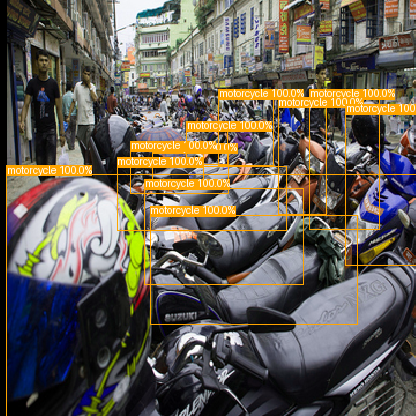

Example's shape: torch.Size([3, 416, 416])
Label's shape: torch.Size([7, 7, 14])
Original example's shape: torch.Size([3, 416, 416])
Label's support (positions of nonzeros): tensor([[ 2,  2,  2],
        [ 2,  2,  4],
        [ 2,  2,  5],
        [ 2,  2,  6],
        [ 2,  2,  7],
        [ 2,  2,  8],
        [ 2,  2,  9],
        [ 2,  2, 10],
        [ 2,  2, 11],
        [ 2,  2, 12],
        [ 2,  2, 13],
        [ 2,  3,  2],
        [ 2,  3,  4],
        [ 2,  3,  5],
        [ 2,  3,  6],
        [ 2,  3,  7],
        [ 2,  3,  8],
        [ 2,  3,  9],
        [ 2,  3, 10],
        [ 2,  3, 11],
        [ 2,  3, 12],
        [ 2,  3, 13],
        [ 2,  4,  2],
        [ 2,  4,  4],
        [ 2,  4,  5],
        [ 2,  4,  6],
        [ 2,  4,  7],
        [ 2,  4,  8],
        [ 2,  4,  9],
        [ 2,  4, 10],
        [ 2,  4, 11],
        [ 2,  4, 12],
        [ 2,  4, 13],
        [ 2,  5,  2],
        [ 2,  5,  4],
        [ 2,  5,  5],
        [ 2,  5,  6],
        [ 2,

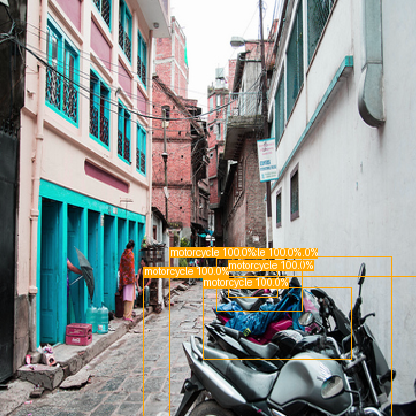

Example's shape: torch.Size([3, 416, 416])
Label's shape: torch.Size([7, 7, 14])
Original example's shape: torch.Size([3, 416, 416])
Label's support (positions of nonzeros): tensor([[ 4,  3,  2],
        [ 4,  3,  4],
        [ 4,  3,  5],
        [ 4,  3,  6],
        [ 4,  3,  7],
        [ 4,  3,  8],
        [ 4,  3,  9],
        [ 4,  3, 10],
        [ 4,  3, 11],
        [ 4,  3, 12],
        [ 4,  3, 13],
        [ 4,  4,  2],
        [ 4,  4,  4],
        [ 4,  4,  5],
        [ 4,  4,  6],
        [ 4,  4,  7],
        [ 4,  4,  8],
        [ 4,  4,  9],
        [ 4,  4, 10],
        [ 4,  4, 11],
        [ 4,  4, 12],
        [ 4,  4, 13],
        [ 5,  4,  2],
        [ 5,  4,  4],
        [ 5,  4,  5],
        [ 5,  4,  6],
        [ 5,  4,  7],
        [ 5,  4,  8],
        [ 5,  4,  9],
        [ 5,  4, 10],
        [ 5,  4, 11],
        [ 5,  4, 12],
        [ 5,  4, 13],
        [ 6,  5,  2],
        [ 6,  5,  4],
        [ 6,  5,  5],
        [ 6,  5,  6],
        [ 6,

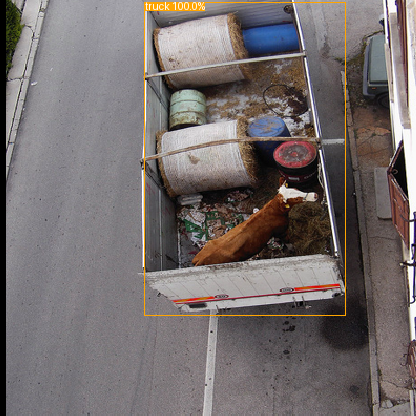

Example's shape: torch.Size([3, 416, 416])
Label's shape: torch.Size([7, 7, 14])
Original example's shape: torch.Size([3, 416, 416])
Label's support (positions of nonzeros): tensor([[ 2,  4,  0],
        [ 2,  4,  4],
        [ 2,  4,  5],
        [ 2,  4,  6],
        [ 2,  4,  7],
        [ 2,  4,  8],
        [ 2,  4,  9],
        [ 2,  4, 10],
        [ 2,  4, 11],
        [ 2,  4, 12],
        [ 2,  4, 13]])
Negative labels: 0
Example intensity range: 0.0 1.0
Object class names: ['truck', 'car', 'motorcycle', 'bus']
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
demo_set = COCODataset(set_type='train', normalize=False, augment=True)
print(f"Number of images in the set: {len(demo_set)}")

obj_classes = demo_set.vehicle_classes  # ['truck', 'car', 'motorcycle', 'bus']

negative_labels = 0
smallest = float('inf')
largest = float('-inf')
example_count = 0
selected_examples = 0

# 4 examples
for idx in range(len(demo_set)):
    example, label, original_data = demo_set[idx]
    example_count += 1

    if selected_examples < 4:
        if torch.sum(label) > 0:
            selected_examples += 1
            negative_labels += torch.sum(label < 0).item()
            smallest = min(smallest, torch.min(example).item())
            largest = max(largest, torch.max(example).item())

            print(f"Example nr. {selected_examples}:")
            plot_boxes(example, label, obj_classes, max_overlap=float('inf'))
            print(f"Example's shape: {example.shape}\nLabel's shape: {label.shape}\nOriginal example's shape: {original_data.shape}")
            print(f"Label's support (positions of nonzeros): {torch.nonzero(label)}")

    if selected_examples >= 4:
        break

print("Negative labels:", negative_labels)
print("Example intensity range:", smallest, largest)

print(f"Object class names: {obj_classes}")
print(label[0, 3, 0:5*B+C])
print(label[1, 3, 0:5*B+C])


#LOSS FUNCTION

In [6]:
def mse_loss(a, b):
    "Calculate the Mean Squared Error (MSE) between two tensors."
    flattened_a = torch.flatten(a, end_dim=-2)
    flattened_b = torch.flatten(b, end_dim=-2).expand_as(flattened_a)
    return F.mse_loss(
        flattened_a,
        flattened_b,
        reduction='sum'
    )
class SumSquaredErrorLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l_coord = 5
        self.l_noobj = 0.5

    def forward(self, p, a):
        # p: prediction, a: ground truth, both with shape (batch, S, 5*B+C)
        # Calculates the IoU for each predicted versus actual bounding box
        self.class_weights = self.class_weights.to(p.device)

        iou = get_iou(p, a)                     # (batch, S, S, B, B)
        max_iou = torch.max(iou, dim=-1)[0]      # (batch, S, S, B)

        # masks
        bbox_mask = bbox_attr(a, 4) > 0.0
        p_template = bbox_attr(p, 4) > 0.0
        obj_i = bbox_mask[..., 0:1]  # (batch, S, S, 1): 1 if at least one object exists in the cell

        # Identifies which of the cell's B bounding box is responsible (the one with the highest IoU)
        responsible = torch.zeros_like(p_template).scatter_(
            -1,
            torch.argmax(max_iou, dim=-1, keepdim=True),
            value=1
        )  # (batch, S, S, B)
        obj_ij = obj_i * responsible  # 1 if an object exists and that bbox is ‘responsible’
        noobj_ij = ~obj_ij  # otherwise, confidence=0

        # Loss on X and Y co-ordinates
        x_losses = mse_loss(
            obj_ij * bbox_attr(p, 0),
            obj_ij * bbox_attr(a, 0)
        )
        y_losses = mse_loss(
            obj_ij * bbox_attr(p, 1),
            obj_ij * bbox_attr(a, 1)
        )
        pos_losses = x_losses + y_losses

        # Loss on dimensions (width and height)
        p_width = bbox_attr(p, 2)
        a_width = bbox_attr(a, 2)
        width_losses = mse_loss(
            obj_ij * torch.sign(p_width) * torch.sqrt(torch.abs(p_width) + EPSILON),
            obj_ij * torch.sqrt(a_width)
        )
        p_height = bbox_attr(p, 3)
        a_height = bbox_attr(a, 3)
        height_losses = mse_loss(
            obj_ij * torch.sign(p_height) * torch.sqrt(torch.abs(p_height) + EPSILON),
            obj_ij * torch.sqrt(a_height)
        )
        dim_losses = width_losses + height_losses

        # Loss on the confidence
        obj_confidence_losses = mse_loss(
            obj_ij * bbox_attr(p, 4),
            obj_ij * torch.ones_like(max_iou)
        )
        noobj_confidence_losses = mse_loss(
            noobj_ij * bbox_attr(p, 4),
            torch.zeros_like(max_iou)
        )

        # Loss for classification
        class_losses = mse_loss(
            obj_i * p[..., :C],
            obj_i * a[..., :C]
        )

        total = self.l_coord * (pos_losses + dim_losses) \
                + obj_confidence_losses \
                + self.l_noobj * noobj_confidence_losses \
                + class_losses
        return total / BATCH_SIZE

# Transfer Learning: Use a pre-trained ResNet as backbone network + fine tuning                 


In [7]:
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
class YOLOv1ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.depth = B * 5 + C

        # Load pre-trained ResNet50
        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)

        # FREEZE first layers of ResNet
        for param in backbone.parameters():
            param.requires_grad = False

        # Unlock the last fine-tuning blocks
        for param in backbone.layer4.parameters():
            param.requires_grad = True

        # Removes the ResNet classifier and adds the detection head
        backbone.avgpool = nn.Identity()
        backbone.fc = nn.Identity()
        self.model = nn.Sequential(
            backbone,
            Reshape(2048, 13, 13),
            DetectionNet(2048)  # Detection head (4 conv + 2 fully connected)
        )

    def forward(self, x):
        return self.model(x)


class DetectionNet(nn.Module):
    """The layers added on for detection:
    4 convolution layers + 2 fully connected layers with LeakyReLU activation function."""

    def __init__(self, in_channels):
        super().__init__()

        inner_channels = 1024
        self.depth = 5 * B + C
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, inner_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(inner_channels, inner_channels, kernel_size=3, stride=2, padding=1),  # (#channels*14*14) -> (#channels*7*7)
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(inner_channels, inner_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(inner_channels, inner_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Flatten(),
            nn.Linear(7 * 7 * inner_channels, 4096),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(4096, S * S * self.depth)  # output: S*S*(5B+C)
        )

    def forward(self, x):
        return torch.reshape(
            self.model(x),
            (-1, S, S, self.depth)
        )

#############################
#       Helper Modules      #
#############################
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = tuple(args)

    def forward(self, x):
        return torch.reshape(x, (-1, *self.shape))

- TRAIN SET AND TEST SET
- TRAIN LOADER AND TEST LOADER





In [25]:
train_set = COCODataset(set_type='train', normalize=True, augment=True)
test_set  = COCODataset(set_type='test',  normalize=True, augment=True)

train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    drop_last=True,
    shuffle=True
)
test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    persistent_workers=True,
    drop_last=True
)

- Instantiate the model with Transfer Learning

- Loss Function Definition

- Optimiser - Fine-tuning on unlocked layers only

- Activates learning rate scheduler for more stable training

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.autograd.set_detect_anomaly(True)

writer = SummaryWriter()
now = datetime.now()

drive_root = os.path.join(DATA_PATH, 'models', 'yolo_v1')
weights_path = os.path.join(drive_root, 'weights', 'model_final_finetuning.pth')

model = YOLOv1ResNet().to(device)

epochs = 50

loss_function = SumSquaredErrorLoss()

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_losses = np.empty((2, 0))
test_losses = np.empty((2, 0))

def save_metrics():
    np.save(os.path.join(drive_root, 'train_losses.npy'), train_losses)
    np.save(os.path.join(drive_root, 'test_losses.npy'), test_losses)


#TRAINING (50 epochs)

In [ ]:
for epoch in tqdm(range(epochs), desc='Epoch'):
    model.train()
    train_loss = 0.0

    for data, labels, _ in tqdm(train_loader, desc='Train', leave=False):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(data)
        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() / len(train_loader)
        del data, labels, predictions
        torch.cuda.empty_cache()

    scheduler.step()
    train_losses = np.append(train_losses, [[epoch], [train_loss]], axis=1)
    writer.add_scalar('Loss/train', train_loss, epoch)

    # Evaluation on the test set every 4 epochs
    if epoch % 4 == 0:
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for data, labels, _ in tqdm(test_loader, desc='Test', leave=False):
                data, labels = data.to(device), labels.to(device)
                predictions = model(data)
                loss = loss_function(predictions, labels)
                test_loss += loss.item() / len(test_loader)
                del data, labels, predictions
                torch.cuda.empty_cache()
        test_losses = np.append(test_losses, [[epoch], [test_loss]], axis=1)
        writer.add_scalar('Loss/test', test_loss, epoch)
        save_metrics()

    # checkpoints every 5 epochs
    weight_dir = os.path.join(drive_root, 'weights')
    os.makedirs(weight_dir, exist_ok=True)

    if epoch % 5 == 0:
        model_path = os.path.join(weight_dir, f'epoch_{epoch}.pth')
        torch.save(model.state_dict(), model_path)
        print(f"Modello salvato: {model_path}")

#save the final model
final_model_path = os.path.join(weight_dir, 'model_final_finetuning.pth')
torch.save(model.state_dict(), final_model_path)
print(f"Modello finale salvato in: {final_model_path}")
save_metrics()

Train: 100%|██████████| 31/31 [01:01<00:00,  1.59s/it]
                                                      
Epoch:   2%|▏         | 1/50 [02:17<1:52:01, 137.17s/it]

Modello salvato: /content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/epoch_0.pth



Train: 100%|██████████| 31/31 [00:59<00:00,  1.67s/it]
                                                      
Epoch:  12%|█▏        | 6/50 [09:02<1:08:13, 93.04s/it]

Modello salvato: /content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/epoch_5.pth



Train: 100%|██████████| 31/31 [01:03<00:00,  2.80s/it]
                                                      
Epoch:  22%|██▏       | 11/50 [16:06<59:34, 91.65s/it]

Modello salvato: /content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/epoch_10.pth



Train: 100%|██████████| 31/31 [00:59<00:00,  1.64s/it]
                                                      
Epoch:  32%|███▏      | 16/50 [22:57<48:39, 85.86s/it]

Modello salvato: /content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/epoch_15.pth



Train: 100%|██████████| 31/31 [01:05<00:00,  1.66s/it]
                                                      
Train: 100%|██████████| 31/31 [01:00<00:00,  1.74s/it]
                                                      
Epoch:  42%|████▏     | 21/50 [30:57<50:31, 104.53s/it]

Modello salvato: /content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/epoch_20.pth



Train: 100%|██████████| 31/31 [00:58<00:00,  1.52s/it]
                                                      
Epoch:  52%|█████▏    | 26/50 [37:03<32:34, 81.45s/it]

Modello salvato: /content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/epoch_25.pth



Train: 100%|██████████| 31/31 [00:59<00:00,  1.58s/it]
                                                      
Epoch:  62%|██████▏   | 31/50 [43:28<25:00, 78.95s/it]

Modello salvato: /content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/epoch_30.pth



Train: 100%|██████████| 31/31 [01:00<00:00,  1.77s/it]
                                                      
Epoch:  72%|███████▏  | 36/50 [49:50<17:44, 76.04s/it]

Modello salvato: /content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/epoch_35.pth



Train: 100%|██████████| 31/31 [01:05<00:00,  1.66s/it]
                                                      
Train: 100%|██████████| 31/31 [00:59<00:00,  1.64s/it]
                                                      
Epoch:  82%|████████▏ | 41/50 [57:15<13:51, 92.43s/it]

Modello salvato: /content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/epoch_40.pth



Train: 100%|██████████| 31/31 [01:00<00:00,  1.64s/it]
                                                      
Epoch:  92%|█████████▏| 46/50 [1:03:40<05:36, 84.24s/it]

Modello salvato: /content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/epoch_45.pth



Train: 100%|██████████| 31/31 [01:00<00:00,  1.65s/it]
                                                      
Epoch: 100%|██████████| 50/50 [1:08:45<00:00, 82.50s/it]


Modello finale salvato in: /content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/model_final_finetuning.pth


#LOSS FUNCTION

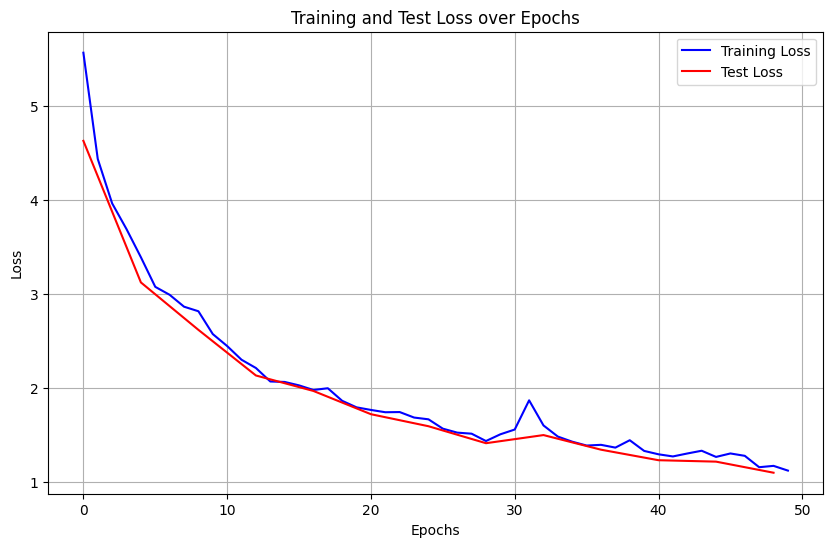

In [8]:
import numpy as np
import matplotlib.pyplot as plt

train_losses = np.load('/content/drive/MyDrive/COCO_Filtered/models/yolo_v1/train_losses.npy')
test_losses = np.load('/content/drive/MyDrive/COCO_Filtered/models/yolo_v1/test_losses.npy')

epochs_train = train_losses[0]
train_loss_values = train_losses[1]

epochs_test = test_losses[0]
test_loss_values = test_losses[1]

plt.figure(figsize=(10, 6))
plt.plot(epochs_train, train_loss_values, label='Training Loss', color='blue')
plt.plot(epochs_test, test_loss_values, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
train_losses = np.load("/content/drive/MyDrive/COCO_Filtered/models/yolo_v1/train_losses.npy")
test_losses = np.load("/content/drive/MyDrive/COCO_Filtered/models/yolo_v1/test_losses.npy")

train_loss_at_49 = train_losses[1][-1]
print(f"Train Loss at 49ª epoch: {train_loss_at_49:.6f}")

idx_test = np.where(test_losses[0] == 48)[0][0]
test_loss_at_48 = test_losses[1][idx_test]
print(f"Test Loss at 48ª epoch: {test_loss_at_48:.6f}")


Train Loss at 49ª epoch: 1.123918
Test Loss at 48ª epoch: 1.101432


#LOAD THE FINAL MODEL

In [ ]:
file_path = "/content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/model_final_finetuning.pth"

model = YOLOv1ResNet().to(device)

try:
    model.load_state_dict(torch.load(file_path, map_location=device))
    print("Model correctly loaded!")
except Exception as e:
    print(f"ERROR in model loading: {e}")


drive_root = "/content/drive/MyDrive/COCO_Filtered/models/yolo_v1"

# Automatically finds the last saved model
latest_weights = None
for root, dirs, files in os.walk(drive_root, topdown=False):
    if "model_final_finetuning.pth" in files:
        latest_weights = os.path.join(root, "model_final_finetuning.pth")
        break

if latest_weights:
    print(f"Loading the model from: {latest_weights}")

    model = YOLOv1ResNet().to(device)

    # load weights
    model.load_state_dict(torch.load(latest_weights, map_location=device))

    model.eval()
    print("Model loaded and ready to go!")
else:
    print("ERROR: No model found!")


Model correctly loaded!
Loading the model from: /content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/model_final_finetuning.pth
Model loaded and ready to go!


#CONFUSION MATRIX

Costruzione Confusion Matrix: 100%|██████████| 31/31 [07:27<00:00, 14.43s/it]


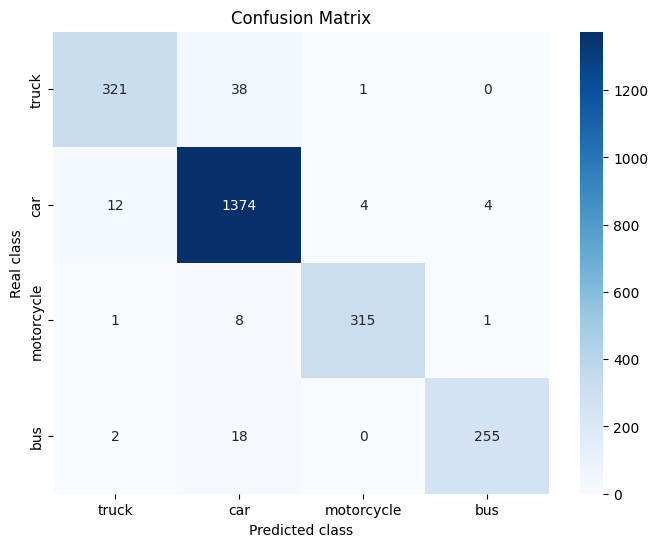

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

obj_classes = ['truck', 'car', 'motorcycle', 'bus']
C = len(obj_classes)  # 4

# Lists for collecting true and predicted labels
true_labels = []
pred_labels = []

model.eval()

with torch.no_grad():
    for images, labels, originals in tqdm(test_loader, desc="Costruzione Confusion Matrix"):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)

        batch_size = images.shape[0]

        for b in range(batch_size):
            for i in range(S):
                for j in range(S):
                    gt_cell = labels[b, i, j, :C]

                    if gt_cell.sum() > 0:
                        true_class = torch.argmax(gt_cell).item()

                        # Extraction of the aforementioned class
                        pred_cell = predictions[b, i, j, :C]
                        pred_class = torch.argmax(pred_cell).item()

                        # Save actual and predicted labels
                        true_labels.append(true_class)
                        pred_labels.append(pred_class)

if not true_labels or not pred_labels:
    print("No valid labels found. Check dataset and predictions.")
else:
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(C)))

    # Visualization of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=obj_classes, yticklabels=obj_classes)
    plt.xlabel("Predicted class")
    plt.ylabel("Real class")
    plt.title("Confusion Matrix")
    plt.show()


#ACCURACY, PRECISION, RECALL, F1-SCORE

In [ ]:
from sklearn.metrics import classification_report

if not true_labels or not pred_labels:
    print(" No valid labels found. Check dataset and predictions.")
else:
    #classification report
    print(classification_report(true_labels, pred_labels, target_names=obj_classes, zero_division=0))


              precision    recall  f1-score   support

       truck       0.96      0.89      0.92       360
         car       0.96      0.99      0.97      1394
  motorcycle       0.98      0.97      0.98       325
         bus       0.98      0.93      0.95       275

    accuracy                           0.96      2354
   macro avg       0.97      0.94      0.96      2354
weighted avg       0.96      0.96      0.96      2354



#TEST

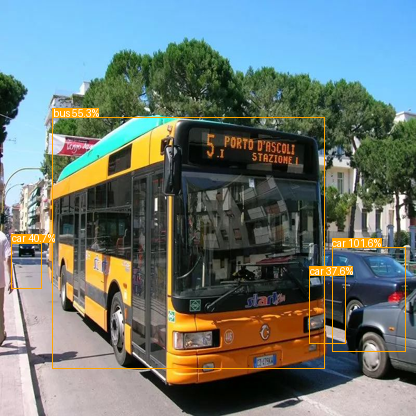

In [ ]:
obj_classes = ['truck', 'car', 'motorcycle', 'bus']
img_path = '/content/drive/MyDrive/COCO_Filtered/bus2.jpg'

image = Image.open(img_path).convert('RGB')

image_resized = image.resize(IMAGE_SIZE)

# Transforms the image into a tensor
transform = T.ToTensor()
image_tensor = transform(image_resized)

# normalization
normalize_transform = T.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
image_tensor_normalized = normalize_transform(image_tensor)

input_tensor = image_tensor_normalized.unsqueeze(0).to(device)

# denormalization
def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Clone the tensor so as not to modify the original
    tensor = tensor.clone().detach()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)

#EVALUATION
model.eval()
with torch.no_grad():
    prediction = model(input_tensor)

prediction = prediction[0]

image_tensor_denorm = denormalize_image(image_tensor_normalized.cpu())

plot_boxes(image_tensor_denorm, prediction.cpu(), obj_classes)


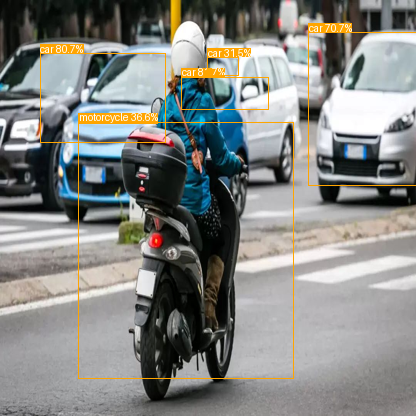

In [ ]:
obj_classes = ['truck', 'car', 'motorcycle', 'bus']
img_path = '/content/drive/MyDrive/COCO_Filtered/moto3.jpg'

image = Image.open(img_path).convert('RGB')

image_resized = image.resize(IMAGE_SIZE)

# Transforms the image into a tensor
transform = T.ToTensor()
image_tensor = transform(image_resized)

# normalization
normalize_transform = T.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
image_tensor_normalized = normalize_transform(image_tensor)

input_tensor = image_tensor_normalized.unsqueeze(0).to(device)

# denormalization
def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Clone the tensor so as not to modify the original
    tensor = tensor.clone().detach()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)

#EVALUATION
model.eval()
with torch.no_grad():
    prediction = model(input_tensor)

prediction = prediction[0]

image_tensor_denorm = denormalize_image(image_tensor_normalized.cpu())

plot_boxes(image_tensor_denorm, prediction.cpu(), obj_classes)


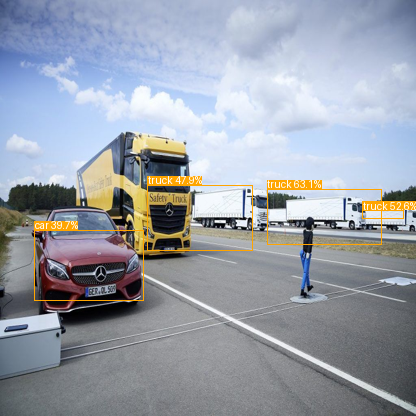

In [ ]:
obj_classes = ['truck', 'car', 'motorcycle', 'bus']
img_path = '/content/drive/MyDrive/COCO_Filtered/truck.jpg'

image = Image.open(img_path).convert('RGB')

image_resized = image.resize(IMAGE_SIZE)

# Transforms the image into a tensor
transform = T.ToTensor()
image_tensor = transform(image_resized)

# normalization
normalize_transform = T.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
image_tensor_normalized = normalize_transform(image_tensor)

input_tensor = image_tensor_normalized.unsqueeze(0).to(device)

# denormalization
def denormalize_image(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Clone the tensor so as not to modify the original
    tensor = tensor.clone().detach()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor.clamp(0, 1)

#EVALUATION
model.eval()
with torch.no_grad():
    prediction = model(input_tensor)

prediction = prediction[0]

image_tensor_denorm = denormalize_image(image_tensor_normalized.cpu())

plot_boxes(image_tensor_denorm, prediction.cpu(), obj_classes)


#Comparison with ResNet backbone


In [ ]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_final = YOLOv1ResNet().to(device)

file_path = "/content/drive/MyDrive/COCO_Filtered/models/yolo_v1/weights/model_final_finetuning.pth"
model_final.load_state_dict(torch.load(file_path, map_location=device))

model_final.eval()

# Load ResNet50 pre-trained
new_backbone = resnet50(weights=ResNet50_Weights.DEFAULT)

# Remove the classification end of ResNet50
new_backbone.avgpool = nn.Identity()
new_backbone.fc = nn.Identity()

# Replace the backbone in the final model
model_final.model[0] = new_backbone



Costruzione Confusion Matrix: 100%|██████████| 31/31 [06:28<00:00, 12.54s/it]


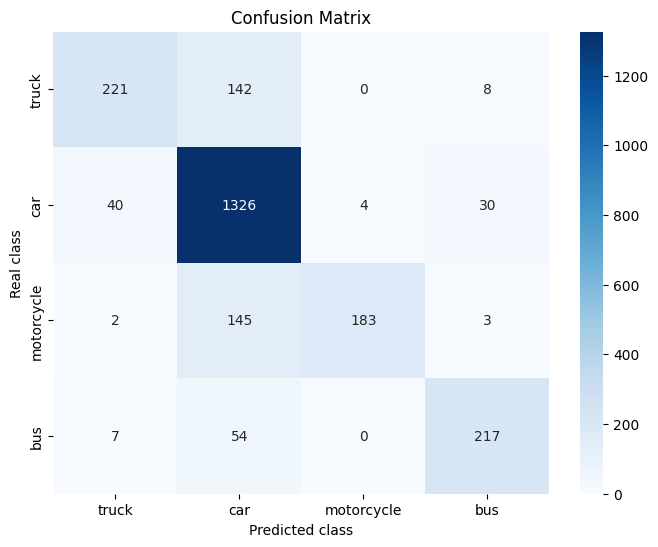

In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

obj_classes = ['truck', 'car', 'motorcycle', 'bus']
C = len(obj_classes)  # 4

# Lists for collecting true and predicted labels
true_labels = []
pred_labels = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_final.to(device)
model_final.eval()

with torch.no_grad():
    for images, labels, originals in tqdm(test_loader, desc="Costruzione Confusion Matrix"):
        images = images.to(device)  # move the images on GPU
        labels = labels.to(device)  # move the images GPU
        predictions = model_final(images)  # Model on GPU

        batch_size = images.shape[0]

        for b in range(batch_size):
            for i in range(S):
                for j in range(S):
                    gt_cell = labels[b, i, j, :C]

                    if gt_cell.sum() > 0:
                        true_class = torch.argmax(gt_cell).item()

                        pred_cell = predictions[b, i, j, :C]
                        pred_class = torch.argmax(pred_cell).item()

                        true_labels.append(true_class)
                        pred_labels.append(pred_class)

true_labels = np.array(true_labels).astype(int)
pred_labels = np.array(pred_labels).astype(int)

if true_labels.size == 0 or pred_labels.size == 0:
    print("No valid labels found. Check dataset and predictions.")
else:
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(C)))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=obj_classes, yticklabels=obj_classes)
    plt.xlabel("Predicted class")
    plt.ylabel("Real class")
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

true_labels = np.array(true_labels).astype(int)
pred_labels = np.array(pred_labels).astype(int)

if true_labels.size == 0 or pred_labels.size == 0:
    print("No valid labels found. Check dataset and predictions.")
elif len(true_labels) != len(pred_labels):
    print("Mismatch: true_labels and pred_labels have different lengths!")
else:
    # Report
    print(classification_report(true_labels, pred_labels, target_names=obj_classes, zero_division=0))

              precision    recall  f1-score   support

       truck       0.82      0.60      0.69       371
         car       0.80      0.95      0.86      1400
  motorcycle       0.98      0.55      0.70       333
         bus       0.84      0.78      0.81       278

    accuracy                           0.82      2382
   macro avg       0.86      0.72      0.77      2382
weighted avg       0.83      0.82      0.81      2382

